# Face recognition using SVM and kernel trick

# Dataset description

This assignment asks you to build a classifier trained on face images. First, let's load the required dataset and see what it is. 

The table contains "straightened" representations of images of people's faces.

Initially, each image is a matrix of size $62 \times 47$ whose values are presumably normalized to a range $[0, 1]$ from the range $[0, 255] \cap \mathbb Z$. The values themselves are responsible for the intensity of the pixel: the larger the value, the lighter the pixel.

Note, from the image (or, what is the same thing, matrix) of size $62 \times 47$ we get a vector of $2914 = 62 \cdot 47$ length.

The column <code>label</code> is responsible for the name of the person depicted in the picture.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Columns: 2915 entries, 0 to label
dtypes: float64(2914), object(1)
memory usage: 29.5+ MB


Let's make sure that we actually see images of people's faces. Let's take the first $15$ rows from the initial dataframe and build the images corresponding to them.

In [4]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

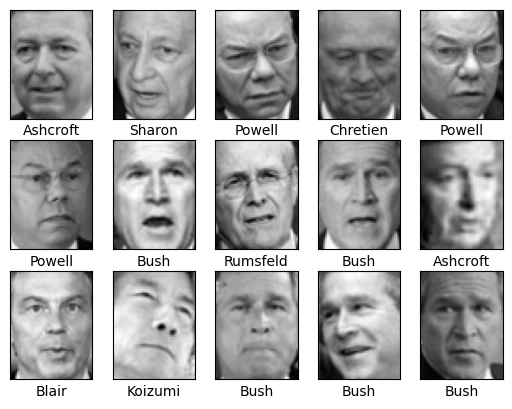

In [5]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

Larger

(-0.5, 46.5, 61.5, -0.5)

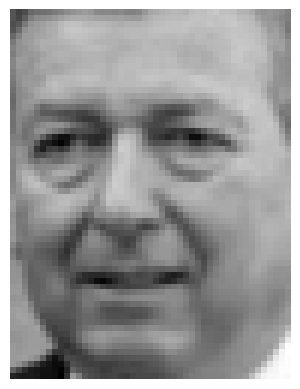

In [6]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# A bit of mischief

Determine the number of different people whose pictures are contained in the dataset.

In [7]:
# < ENTER YOUR CODE HERE >

print(f'number of different people in the dataset: {df.label.nunique()}')

number of different people in the dataset: 12


In [8]:
set(df.label)

{'Ariel Sharon',
 'Colin Powell',
 'Donald Rumsfeld',
 'George W Bush',
 'Gerhard Schroeder',
 'Hugo Chavez',
 'Jacques Chirac',
 'Jean Chretien',
 'John Ashcroft',
 'Junichiro Koizumi',
 'Serena Williams',
 'Tony Blair'}

Construct a histogram of the distribution of objects by class and calculate the proportion of objects in each class.

In [16]:
unique_people = set(df['label'])
len(unique_people)

12

Доля объектов каждого класса:
label
George W Bush        0.340
Colin Powell         0.152
Tony Blair           0.092
Donald Rumsfeld      0.078
Gerhard Schroeder    0.070
Ariel Sharon         0.049
Hugo Chavez          0.045
Junichiro Koizumi    0.038
Jean Chretien        0.035
John Ashcroft        0.034
Serena Williams      0.033
Jacques Chirac       0.033
Name: proportion, dtype: float64


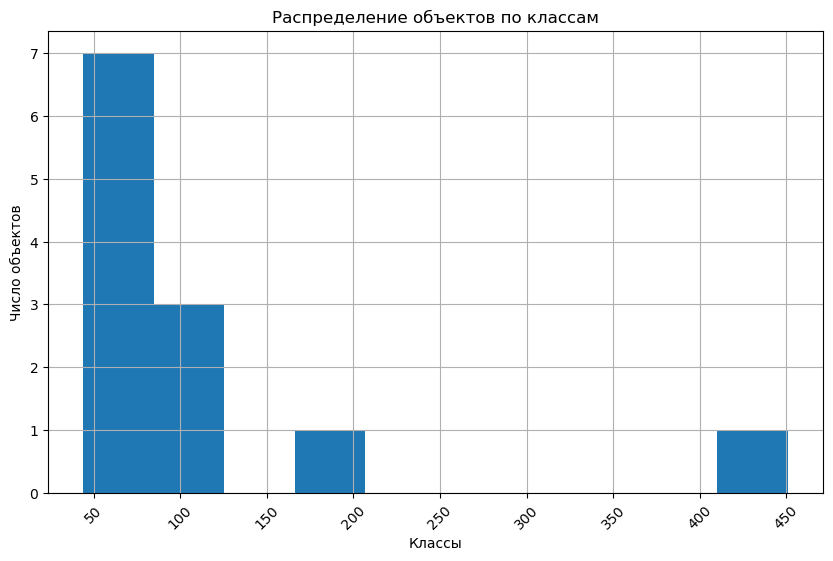

In [19]:
# < ENTER YOUR CODE HERE >
# Построение гистограммы распределения объектов по классам
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='hist')
plt.title('Распределение объектов по классам')
plt.xlabel('Классы')
plt.ylabel('Число объектов')
plt.xticks(rotation=45)
plt.grid()

# Вычисление доли объектов каждого класса
print("Доля объектов каждого класса:")
print(round(df['label'].value_counts(normalize=True), 3))

Based on the available data, match each person with one vector whose coordinates are the average of the corresponding coordinates of all vectors identified with that person.

In [20]:
# < ENTER YOUR CODE HERE >
average_vectors = df.groupby('label').mean().reset_index()
average_vectors

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
1,Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
2,Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
3,George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
4,Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118
5,Hugo Chavez,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,...,0.337647,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052
6,Jacques Chirac,0.348010,0.368152,0.405704,0.436988,0.462686,0.498693,0.531135,0.553060,0.574629,...,0.453832,0.469935,0.480957,0.486067,0.510933,0.537998,0.542751,0.505853,0.456625,0.434997
7,Jean Chretien,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,...,0.526380,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608
8,John Ashcroft,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,...,0.472651,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495
9,Junichiro Koizumi,0.268384,0.253672,0.249699,0.257875,0.297373,0.352044,0.403306,0.441394,0.470819,...,0.505652,0.530437,0.561169,0.558657,0.542304,0.537896,0.532359,0.516750,0.498347,0.509753


Enter the coordinate with index $0$ of the average vector corresponding to the person in your individual assignment.

In [22]:
# < ENTER YOUR CODE HERE >
round(average_vectors[average_vectors['label'] == 'Serena Williams'], 3)

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
10,Serena Williams,0.413,0.39,0.359,0.334,0.337,0.353,0.37,0.385,0.404,...,0.236,0.246,0.262,0.274,0.291,0.308,0.322,0.334,0.348,0.362


Using the average vectors, construct pictures of all the people in the dataset.

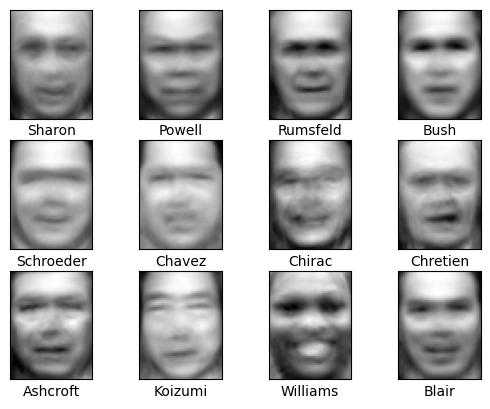

In [27]:
# < ENTER YOUR CODE HERE >
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(average_vectors.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 400, bbox_inches='tight')

The so-called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is often used as a measure of the "similarity" of two objects. It should not be confused with cosine distance.

Construct a similarity matrix of objects based on their averaged vectors. We recommend using a heat map for visualization, e.g. [from the seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [37]:
# < ENTER YOUR CODE HERE >
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(average_vectors.drop('label', axis=1))

TypeError: type numpy.ndarray doesn't define __round__ method

Determine the cosine similarity for a pair of people from your individual assignment based on their corresponding "average" vectors.

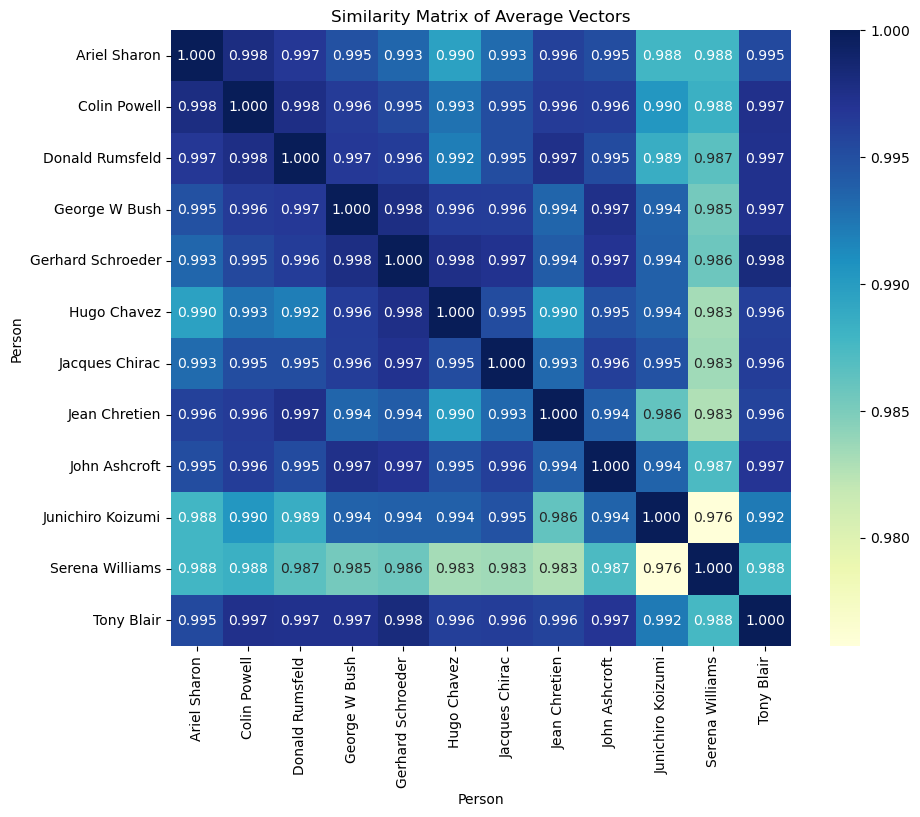

In [36]:
# < ENTER YOUR CODE HERE >
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cs, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=average_vectors['label'], yticklabels=average_vectors['label'])
plt.title("Similarity Matrix of Average Vectors")
plt.xlabel("Person")
plt.ylabel("Person")
plt.show()

# Построение модели

Use <code>train_test_split()</code> to split the dataset into training and test samples with the parameters from your individual assignment. Use stratification by column <code>label</code>.

In [38]:
# < ENTER YOUR CODE HERE >
from sklearn.model_selection import train_test_split
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y)

## First approximation: a basic SVM classifier with a linear kernel

Train the <code>SVC()</code> model on the training dataset with the parameters from your individual assignment.

In [39]:
# < ENTER YOUR CODE HERE >
from sklearn.svm import SVC

svc_lin = SVC(kernel='linear', random_state=21)
svc_lin.fit(X_train, y_train)

SVC(kernel='linear', random_state=21)

Evaluate the model on test dataset. Compute <code>f1_score(average='weighted')</code>.

In [42]:
# < ENTER YOUR CODE HERE >
from sklearn.metrics import f1_score
predict_svc = svc_lin.predict(X_test)

print(round(f1_score(y_test, predict_svc, average='weighted'), 3))

0.763


Overall, a pretty good result, but it makes sense to try to tweak the parameters.

## Selection of hyperparameters

Using <code>GridSearchCV()</code>, perform a hyperparameter selection based on the values from your individual assignment. Observe the training time of the models.

In [43]:
# < ENTER YOUR CODE HERE >
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[21]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

Determine the parameters of the <b>best</b> learned model.

In [45]:
# < ENTER YOUR CODE HERE >
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.774 total time=   1.8s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.778 total time=   1.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.797 total time=   1.7s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.764 total time=   1.7s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.807 total time=   1.7s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=21;, score=0.377 total time=   2.2s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=21;, score=0.377 total time=   2.2s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=21;, score=0.354 total time=   2.2s
[CV 4/5] END C=1, class_weight=N

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [21]}],
             verbose=3)

In [46]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 21}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [48]:
# < ENTER YOUR CODE HERE >
print(round(f1_score(y_test, cv.best_estimator_.predict(X_test), average='weighted'), 3))

0.781


## Dimensionality reduction

Learning took a long time. It makes sense to test what happens if you reduce the dimensionality of the input dataset, e.g. by using <code>PCA</code>. Train the <code>PCA(svd_solver='full')</code> model on the training dataset and determine the minimum number of components required for the explained variance ratio to be greater than <code>0.95</code>.

In [55]:
# < ENTER YOUR CODE HERE >
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')

pca.fit(X_train)

import numpy as np
cumsum = np.cumsum(pca.explained_variance_ratio_)
number_comp = np.argmax(cumsum >= 0.95) + 1
number_comp

172

Re-train the <code>PCA(svd_solver='full')</code> model on the training dataset using the resulting number of principal components. Apply the resulting transformation to the training and test datasets.

In [56]:
# < ENTER YOUR CODE HERE >
pca = PCA(svd_solver='full', n_components=number_comp)

pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

For the data obtained after <code>PCA</code>, similarly to what was done earlier, i.e., using the <code>GridSearchCV()</code>, select hyperparameters from the ranges specified in your individual assignment. Pay special attention to model training time.

In [63]:
# < ENTER YOUR CODE HERE >
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[21]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.750 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.759 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.802 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.731 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=21;, score=0.778 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=21;, score=0.340 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=21;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=21;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=N

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [21]}],
             verbose=3)

Determine the parameters of the <b>best</b> model obtained.

In [64]:
# < ENTER YOUR CODE HERE >
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 21}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [65]:
# < ENTER YOUR CODE HERE >
print(round(f1_score(y_test, cv.best_estimator_.predict(X_test_pca), average='weighted'), 3))

0.768


It can be seen that the quality of the model has changed only slightly, while the training time has decreased significantly.